# Lab 3 A2C
Policy Gradient algorithms are characterized by direct gradient-based optimization of the policy given the reinforcement learning objective of maximizing the expected discounted returns for starting states of the MDP. In the context of policy gradient algorithms, this objective is often denoted as $J_{\theta}$:


$$J_{\theta} = \underset{s_{0} \sim p_{0}}{\mathrm{E}} V^{\pi_{\theta}}(s_0)$$

where $s_{0}$ is the starting state, $p_{0}$ is the starting state distribution, $\pi_{\theta}$ is the policy parameterized by $\theta$, and $V^{\pi_{\theta}}(s_0)$  is the value of starting state under policy $\pi_{\theta}$. Policy Gradient Theorem (PG) [1] shows how to calculate the policy gradient with respect to $\theta$ assuming we do not know the reward and transition functions associated with the MDP:

$$\nabla_{\theta} ~ J_{\theta} = \underset{s \sim p^{\gamma}}{\mathrm{E}} ~ \underset{a \sim \pi_{\theta}}{\mathrm{E}} Q^{\pi_{\theta}}(s,a) \nabla_{\theta} \log \pi_{\theta} (a|s)$$

Above, $\nabla_{\theta}$ denotes the gradient with respect to $\theta$, $ p^{\gamma}$ is the discounted stationary distribution of the MDP under the policy $\pi_{\theta}$ (which we assume exists), and $Q^{\pi_{\theta}}(s,a)$ is the Q-value of a given state-action under policy $\pi_{\theta}$. Policy Gradients are **on-policy** algorithms, as they require data sampled according to the current policy to perform the policy gradient calculation. To this end, similarly to traditional policy iteration, policy gradients loop two steps:

1. Gathering interactions with the environment sampled according to the most recent policy (ie. policy evaluation)
2. Using these interactions and the Monte-Carlo method to estimate the policy gradient (ie. policy improvement)

On-policy policy gradient algorithms are known to suffer from high variance. This high variance is reflected in the policy evaluation step which poses a unique challenge, namely: *how much data should I gather so that my policy improvement steps are well estimated?*. Note, that the quality of estimated $\mathrm{E}_{s \sim p^{\gamma}}$, $\mathrm{E}_{a \sim \pi_{\theta}}$, and $Q^{\pi_{\theta}}(s,a)$ is directly related to the number of environment interactions used for such estimation (ie. batch size). This dependence on batch size to reduce the learning variance contrasts on-policy policy gradient with traditional supervised machine learning.

Extra links:

[1] https://proceedings.neurips.cc/paper/1999/file/464d828b85b0bed98e80ade0a5c43b0f-Paper.pdf - original proof of the policy gradient

[2] https://lilianweng.github.io/posts/2018-04-08-policy-gradient/ - additional info on diverse policy gradient algorithms


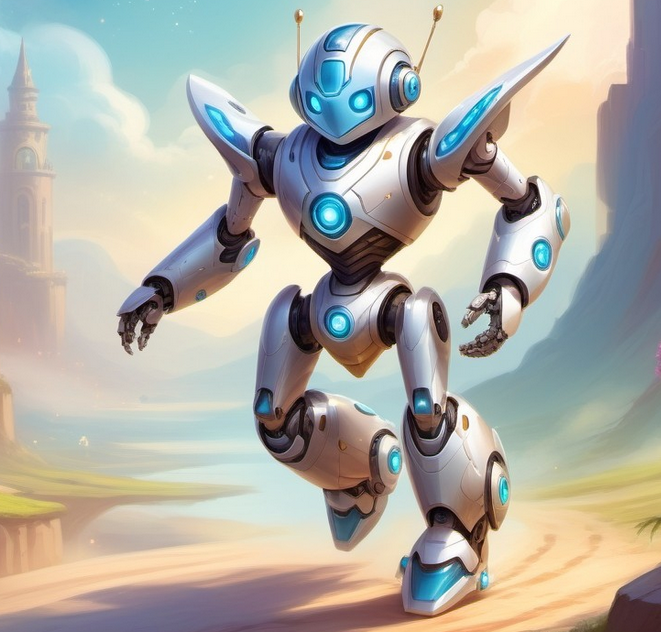

We will be using gymnasium for running our simulation.

In [ ]:
!pip install gymnasium

Let's import all the necessary packages.

In [ ]:
import random
import argparse
import gymnasium as gym
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

from torch.distributions.categorical import Categorical
from tqdm import tqdm

Setting the seeds for reproducibility.

In [ ]:
def seeding(seed):
   random.seed(seed)
   np.random.seed(seed)
   torch.manual_seed(seed)
   torch.backends.cudnn.deterministic = True

## A2C (Advantage Actor-Critic)

Recall the policy gradient equation:

$$\nabla_{\theta} ~ J_{\theta} = \underset{s \sim p^{\gamma}}{\mathrm{E}} ~ \underset{a \sim \pi_{\theta}}{\mathrm{E}} Q^{\pi_{\theta}}(s,a) \nabla_{\theta} \log \pi_{\theta} (a|s)$$

As discussed earlier, we update the policy parameter by using Monte Carlo updates (i.e. taking random samples). This introduces an inherent variability in the encountered state-actions and results in different policy updates dependent on the sampled transitions. This result in noisy gradients, and hence causes unstable learning. As discussed in [1], we can reduce the variance at zero bias cost by introducing the advantage term $A^{\pi_{\theta}}(s,a)$:

$$\nabla_{\theta} ~ J_{\theta} = \underset{s \sim p^{\gamma}}{\mathrm{E}} ~ \underset{a \sim \pi_{\theta}}{\mathrm{E}} A^{\pi_{\theta}}(s,a) \nabla_{\theta} \log \pi_{\theta} (a|s)$$

Intuitively, making the Q-values smaller by subtracting a baseline from it, will result in smaller gradients, and thus smaller and more stable updates. Although the baseline can take various forms, we will focus on Advantage Actor-Critic (A2C) which is a specific variant of the policy gradient that leverages the concept of the advantage function. This function measures by how much better an action is compared to the average action in a given state. By incorporating this advantage information, A2C focuses the learning process on actions that have a significantly higher value than the typical action taken in that state.

$$A^{\pi_{\theta}}(s,a) = Q^{\pi_{\theta}}(s,a) - V^{\pi_{\theta}}_{\phi}(s)$$

In this setup, $V^{\pi_{\theta}}_{\phi}(s)$ is the state value function modeled by a neural network and referred to as the "critic". In contrast, we estimate $Q^{\pi_{\theta}}(s,a)$ by the observed returns in the gathered on-policy data. Then, we can use these returns to supervise the critic. The critic learns by simple mean squared error according to the following:

$$\mathcal{L}_{\phi} = (V^{\pi_{\theta}}_{\phi}(s) - Q^{\pi_{\theta}}(s,a))^2$$




## Task 1: Train Network with A2C to solve CartPole

### 1.1 - Calculating returns given truncate and terminal signals

We start with implementing our online buffer. The buffer stores the on-policy data as an array of $B$ transitions $[(s_1, a_1, r_1, s^{'}_{1}, T_{1}, C_{1}), (s_2, a_2, r_2, s^{'}_{2}, T_{2}, C_{2}), ..., (s_B, a_B, r_B, s^{'}_{B}, T_{B}, C_{B})]$, with $T$ denoting the terminal signal and $C$ denoting the truncate signal of the MDP. Terminal and truncate signals are used to model different events in the MDP. Terminal state denotes that the simulation is ending because the agent has reached a state after which the MDP finishes (eg. robot falls into a pit), whereas the truncation denotes that the simulation is ending because we reached the maximum episode length but the MDP should in principle continue (eg. the robot is solving its task and it seems that nothing interesting will happen in this episode). We differentiate these signals because they affect how we calculate our values:

1. We do not want to sum rewards after the terminal state - this reflects the fact that acting after termination yields no rewards
2. We want to sum rewards after the truncate state - this reflects that since the MDP would in principle continue, our agent would gather rewards if deployed in the real world and we want our values and Q-values to reflect that.

We want to use our on-policy transitions to calculate the policy gradient, and estimating Q-values is one of the required steps. We calculate Q-values via Monte-Carlo approximation:

$$ Q^{\pi_{\theta}}(s_i,a_i) \approx \sum_{t=0}^{t=T} \gamma^{t} r_{i+t}$$

Above, $T$ denotes the terminal state (ie. an episode when the MDP finishes). It might be that the batch of our gathered trajectory did not reach the terminal state. Then, we bootstrap the Q-values with the critic. More precisely, consider a batch $[(s_1, a_1, r_1, s^{'}_{1}, T_{1}, C_{1}), (s_2, a_2, r_2, s^{'}_{2}, T_{2}, C_{2}), ..., (s_B, a_B, r_B, s^{'}_{B}, T_{B}, C_{B})]$ where all states are neither terminal or truncate. Then we approximate the Q-values according to:

$$ Q^{\pi_{\theta}}(s_i,a_i) \approx \sum_{t=0}^{t=B} \gamma^{t} r_{i+t} + \gamma^{B+1} V^{\pi_{\theta}}_{\phi}(s_{B}^{'})$$

Finally, note that when a truncate signal is issued, we reset the environment. For example, consider a batch $[(s_1, a_1, r_1, s^{'}_{1}, T_{1}, C_{1}), (s_2, a_2, r_2, s^{'}_{2}, T_{2}, C_{2}), ..., (s_B, a_B, r_B, s^{'}_{B}, T_{B}, C_{B})]$ where $C_{2} = 1$ is a truncation signal. Then we would calculate Q-values for the first state-action according to:

$$ Q^{\pi_{\theta}}(s_1,a_1) \approx r_{1} + \gamma ~ r_{2} + \gamma^{2} ~ V^{\pi_{\theta}}_{\phi}(s_{2}^{'}) $$

We have to use such an early bootstrap because since $C_{2} = 1$, the environment was restarted between $s_2$ and $s_3$. As such, the rewards from $s_3$ are coming from a different episode.


In [ ]:
class OnlineBuffer:
    def __init__(self, cfg, env, batch_size):
        self.cfg = cfg
        self.states = torch.zeros((batch_size, *env.observation_space.shape)).to(cfg.device)
        self.next_states = torch.zeros((batch_size, *env.observation_space.shape)).to(cfg.device)
        self.actions = torch.zeros((batch_size, 1)).to(cfg.device)
        self.rewards = torch.zeros((batch_size, 1)).to(cfg.device)
        self.terminals = torch.zeros((batch_size, 1)).to(cfg.device)
        self.truncates = torch.zeros((batch_size, 1)).to(cfg.device)

    def add(self, idx, state, next_state, action, reward, terminal, truncate):
        self.states[idx] = state
        self.next_states[idx] = next_state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.terminals[idx] = terminal
        self.truncates[idx] = truncate

    def calculate_returns(self, agent):
        """
        This method calculates the returns for each state-action pair stored in the buffer.
        It uses the agent's network to estimate the value of the next states and computes the returns using the Bellman equation.
        The method handles terminal states and truncation.
        """

        ### TODO ###
        returns = torch.zeros_like(self.rewards).to(self.cfg.device)
        next_value = agent.network.get_value(self.next_states[-1])

        for i in reversed(range(len(self.rewards))):
            if self.terminals[i]:
                next_value = 0
            elif self.truncates[i]:
                next_value = agent.network.get_value(self.next_states[i])

            returns[i] = self.rewards[i] + self.cfg.discount * next_value
            next_value = returns[i]

        ### DONE ###
        return returns.detach()

### 1.2 - Update of A2C

In [ ]:
class A2C:
    def __init__(self, cfg, env, model_class, batch_size) -> None:
        self.cfg = cfg
        self.batch_size = batch_size
        self.network = model_class(cfg, env).to(cfg.device)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=cfg.lr, eps=1e-5)

    def update(self, iteration, states, actions, returns, baseline):
        """
        Performs a single update step on the model using the provided batch of data.

        Parameters:
            iteration (int): Current iteration number, used for logging and adjustments in learning rates or other parameters.
            states (Tensor): Batch of states from the environment.
            actions (Tensor): Batch of actions taken by the agent.
            returns (Tensor): Batch of returns (cumulative discounted rewards).
            baseline (bool): If True, use the baseline (value function) to calculate advantages. If False, use returns directly.
        """
        assert baseline in [False, True]
        ### TODO ###

        # 1. Calculate the value predictions for the current states
        # 2. Calculate advantages (If True, use the baseline (value function) to calculate advantages. If False, use returns directly.)
        # 3. Calculate log probabilities of the taken actions
        # 4. Calculate policy gradient loss
        # 5. Calculate value loss as the MSE between predicted and actual returns
        # 6. Combine losses

        ### DONE ###
        # 1.
        values = self.network.get_value(states)
        # 2.
        advantages = returns - values.detach() if baseline else returns
        # 3.
        logprob = self.network.get_logprob(states, actions)
        # 4.
        policy_loss = -(logprob * advantages).mean()
        # 5.
        value_loss = torch.nn.functional.mse_loss(values, returns)
        # 6.
        loss = policy_loss + self.cfg.vf_coef * value_loss

        # Perform backpropagation
        loss.backward()

        # noise estimation
        self.after_update(iteration)

    def after_update(self, iteration):
        self.optimizer.step()
        self.optimizer.zero_grad()

    def _evaluation_rollout(self, eval_env):
        returns = 0.0
        state, _ = eval_env.reset(seed=random.randint(0, 1e6))
        state = torch.from_numpy(np.array(state)).to(self.cfg.device).float()
        while True:
            action = self.network.forward(state.unsqueeze(0))[0]
            next_state, reward, terminal, truncate, _ = eval_env.step(action.cpu().numpy())
            returns += reward

            if terminal or truncate:
                break
            state = next_state
            state = torch.from_numpy(np.array(state)).to(self.cfg.device).float()
        return returns

    def evaluate(self, eval_env, n_samples):
        returns = 0.0
        for i in range(n_samples):
            returns += self._evaluation_rollout(eval_env) / n_samples
        return returns

Simple network which should be able to solve CartPole

In [ ]:
class CartpoleNetwork(nn.Module):
    def __init__(self, cfg, env):
        """
        self.critic:
            A sequential neural network with two linear layers.
            The input size is determined by the observation space of the environment.
            The output is a single value representing the estimated value function.

        self.actor:
            A sequential neural network with two linear layers.
            The input size is determined by the observation space of the environment.
            The output size is equal to the number of actions in the action space of the environment.

        init_weights:
            A function to initialize the weights of the linear layers using the Xavier normal initialization
        """
        super().__init__()
        self.cfg = cfg
        self.critic = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
        self.actor = nn.Sequential(
            nn.Linear(np.array(env.observation_space.shape).prod(), 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n),
        )

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0)

        self.actor.apply(init_weights)
        self.critic.apply(init_weights)

    def forward(self, state):
        """
        This method takes a state tensor as input and returns an action tensor.
        1. Passes the state through the actor network to get logits.
        2. Creates a Categorical distribution from the logits.
        3. Samples an action from the distribution.
        """
        with torch.no_grad():
            logits = self.actor(state)
        distribution = Categorical(logits=logits)
        action = distribution.sample()
        return action

    def get_logprob(self, states, actions):
        """
        This method takes state and action tensors as input and returns the log probabilities of the actions given the states.
        1. Passes the states through the actor network to get logits.
        2. Computes the log probabilities of the given actions using the softmax function and gathering the log probabilities at the action indices.
        """
        logits = self.actor(states)
        logprobs = nn.functional.softmax(logits, dim=-1).log().gather(1, actions.long())
        return logprobs

    def get_value(self, states):
        """
        This method takes a state tensor as input and returns the estimated value function by passing the states through the critic network.
        """
        return self.critic(states)

    def get_entropy(self, states):
        """
        This method takes a state tensor as input and returns the entropy of the action distribution
        by passing the states through the actor network and computing the entropy of the resulting Categorical distribution.
        """
        with torch.no_grad():
            logits = self.actor(states)
        distribution = Categorical(logits=logits)
        return distribution.entropy()

    def get_actor_grads(self):
        """
        This method returns the flattened gradients of the actor network's parameters.
        1. Gets a list of all parameters in the actor network.
        2. Flattens the gradients of each parameter (if the gradient exists) and converts them to a column vector.
        3. Concatenates all the column vectors into a single tensor.
        """
        ### TODO ###
        grads = [p.grad.view(-1) for p in self.actor.parameters() if p.grad is not None]
        grad = torch.cat(grads)
        ### DONE ###
        return grad

In [ ]:
def make_cartpole_env(env_id, render_mode=None):
    return gym.make(env_id, render_mode=render_mode)

Simple trainig loop, in each iteration we collect on-policy data and store them in the buffer, then we calculate the discounted returns, and update the agent. We also evaluate the agent periodiacally.

In [ ]:
def train(cfg, agent, env, eval_env, seed, batch_size, baseline=True, verbose=False):
    num_policy_updates = cfg.max_steps // batch_size
    seeding(seed)

    buffer = OnlineBuffer(cfg, env, batch_size)

    # start the game
    state, _ = env.reset(seed=random.randint(0, 1e6))
    state = torch.from_numpy(np.array(state)).to(cfg.device).float()

    # main loop
    eval_results = {}
    env_steps = 0
    for iteration in tqdm(range(num_policy_updates)):
        # evaluate policy
        if iteration % cfg.eval_every == 0:
            eval_result = agent.evaluate(eval_env, 25)
            eval_results[env_steps] = eval_result

            if verbose:
                print(f"env_steps: {env_steps}, eval_result: {eval_result}")

        # gather on-policy data
        for step in range(0, batch_size):
            action = agent.network.forward(state.unsqueeze(0))[0]
            next_state, reward, terminal, truncate, infos = env.step(action.cpu().numpy())
            next_state = torch.from_numpy(np.array(next_state)).to(cfg.device).float()
            buffer.add(step, state, next_state, action, reward, terminal, truncate)
            if terminal or truncate:
                next_state, _ = env.reset(seed=random.randint(0, 1e6))
                next_state = torch.from_numpy(np.array(next_state)).to(cfg.device).float()
            state = next_state

        # calculate returns
        returns = buffer.calculate_returns(agent)

        # update actor-critic
        agent.update(iteration, buffer.states, buffer.actions, returns, baseline)

        env_steps += batch_size

    eval_result = agent.evaluate(eval_env, 25)
    eval_results[env_steps] = eval_result
    return eval_results

In [ ]:
def plot_rewards(results):
    fig, ax1 = plt.subplots()
    ax1.ticklabel_format(useOffset=False, style="plain")

    seed = []
    xs = []
    ys = []
    for i, data in enumerate(results):
        for key, val in data.items():
            seed.append(i)
            xs.append(key)
            ys.append(val)

    df = pd.DataFrame({
        "seed": seed,
        "env_steps": xs,
        "rewards": ys,
    })

    sns.lineplot(data=df, x='env_steps', y='rewards', ax=ax1)

    ax1.grid(True)
    plt.title("Rewards", fontdict={"fontsize": 14})
    fig.tight_layout()
    fig.show()

In [ ]:
def get_eval_results(cfg, algo_class, make_env, model_class):
    results = []
    for seed in range(cfg.n_seeds):
        env = make_env(cfg.env_name)
        eval_env = make_env(cfg.env_name)
        agent = algo_class(cfg, env, model_class, cfg.batch_size)

        eval_results = train(cfg, agent, env, eval_env, seed, cfg.batch_size, cfg.baseline)
        results.append(eval_results)

    return results

Sanity check that A2C implementation works

In [ ]:
cfg = argparse.Namespace(**{
    'n_seeds': 5,
    'batch_size': 128,
    'max_steps': 20000,
    'lr': 0.001,
    'discount': 0.99,
    'vf_coef': 0.5,
    'device': 'cpu', # cpu or cuda
    'env_name': 'CartPole-v1',
    'eval_every': 25,
    'baseline': True,
})

eval_results = get_eval_results(cfg, A2C, make_cartpole_env, CartpoleNetwork)

100%|██████████| 156/156 [00:14<00:00, 10.56it/s]


You should be able to get the return to around **100-150** at the end of this training.

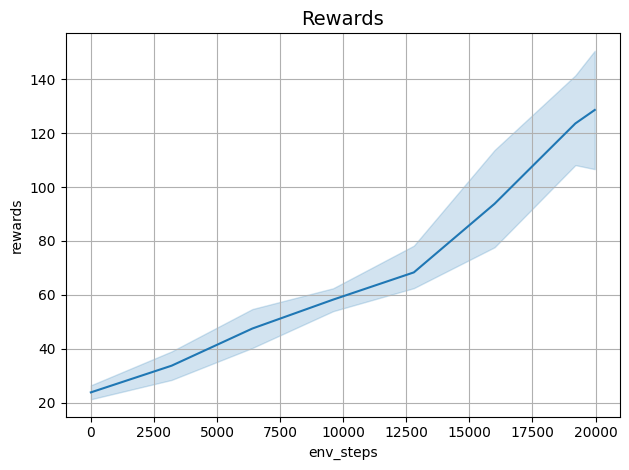

In [ ]:
plot_rewards(eval_results)